<a href="https://colab.research.google.com/github/robin9804/Openholo_Val/blob/master/RS_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

!pip install plyfile
import plyfile

# RS method 검증 과정

1) point cloud reading

2) RS propagation -> complex image 추출

3) Encoding - openholo 사용 가능


In [7]:
# parameters
mm = 10e-3
um = mm*mm
nm = um*mm
wvl_R = 639 * nm  # Red
wvl_G = 525 * nm  # Green
wvl_B = 463 * nm  # Blue

def delta(wvl):
    return wvl * 10  # sampling period

def k0(wvl):
    return (np.pi * 2) / wvl  # wave number

pp = 3.45 * um  # pixel to pixel parameter

# resolution setting
width = 1080 
height = 1080

# PLY 파일 구성

ply  
format ascii 1.0  
comment Point Cloud Data Format in OpenHolo Library v1.0  
element color 1  
property int channel  
element vertex 7493  
property float x  
property float y  
property float z  
property uchar red  
property uchar green  
property uchar blue  
property double phase  
end_header


1번 항목이 꼭지점(Vertex), 7493개 꼭지점. x, y, z, Red, Green, Blue, phase로 구성되어있음


In [10]:
# read PLY file and convert to numpy array
with open('drive/My Drive/Colab Notebooks/data/dice_100000.ply', 'rb') as f:
    plydata = plyfile.PlyData.read(f)
data = np.array(plydata.elements[1].data)

In [11]:
# PLY data 검증
#np.exp(1j*data['phase'][0])
#plydata.elements[0]
data['x'][1]

0.10625

# R-S diffraction with Anti-alliasing

x, y 범위를 x0 - abs(tx / sqrt(1-tx**2)) < x 로 가줘야 한다.

결국 프레넬 회절 공식은 이러한 범위에 의해 zero padding된 형태로 남게 된다.


In [13]:
# define R-S method impulse response and Fresnel Integral method
def h_RS(x1, y1, x2, y2, z, wvl):
    """
    RS impulse response
    """
    r = np.sqrt((x1-x2)**2 + (y1-y2)**2 + z**2)
    h = (z / (1j * wvl)) * (np.exp(1j*k0(wvl)*r) / r **2)
    return h

def h_Fresnel(x, y, z, wvl):
    """
    Fresnel integral inpulse response
    """
    h = (np.exp(1j*k*z)/ 1j*wvl*z) * np.exp(1j*(k0(wvl)/(2*z))*(x**2 + y**2))
    return h

# tx, ty for anti alliasing 
def txy(wvl):
    return wvl / (2 * pp)

def anti(wvl, z):
    t = (txy(wvl) / np.sqrt(1 - txy(wvl) ** 2)) * z
    return np.abs(t)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: ComplexWarning: Casting complex values to real discards the imaginary part


0  th cash done
1  th cash done
2  th cash done


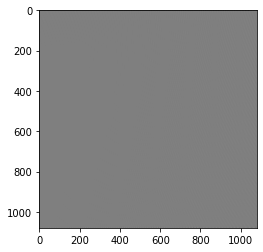

In [26]:
# R-S method
z1 = 0.5
phase = data['phase'][0]  # 5.059415

def RS_kernel_conv(n, j, i, x2, y2, z1, wvl):
    if wvl == wvl_R: 
        return data['red'][n]* h_RS(data['x'][n], data['y'][n],x2, y2, data['z'][n] - z1, wvl )
    elif wvl == wvl_G:
        return data['green'][n]* h_RS(data['x'][n], data['y'][n],x2, y2, data['z'][n] - z1, wvl )
    elif wvl == wvl_B:
        return data['blue'][n]* h_RS(data['x'][n], data['y'][n],x2, y2, data['z'][n] - z1, wvl )
    else:
        print("wrong number")

def RS_hologen(wvl, z):
    """
    RS method 로 홀로그램 생성하는 함수
    """    
    RS_in = np.zeros((width,height))
    for n in range(3):
        RS_cash = np.zeros((width,height))
        for i in range(width):
            x2 = ((i-width)/2) * pp
            if data['x'][n] - anti(wvl, z) < x2 < data['x'][n] +anti(wvl, z):
                for j in range(height):
                    y2 = ((j-height)/2) * pp
                    if data['y'][n] - anti(wvl, z) < y2 < data['y'][n] +anti(wvl, z):
                        RS_cash[j, i] = RS_kernel_conv(n, j, i,x2, y2, z, wvl)
                        #RS_cash[j, i] = data['red'][n]* h_RS(data['x'][n], data['y'][n],x2, y2, data['z'][n] - z1, wvl_R )
                    else:
                        pass
            else:
                pass
        # crop을 계산해서 넣어주기
        RS_in = RS_in + RS_cash
        print(n , " th cash done")
    return RS_in




RS_mean = RS_hologen(wvl_R, 0.5)
#RS_mean /= np.max(RS_mean)
plt.imshow(RS_mean, cmap = 'gray')

In [20]:
RS_mean

array([[-1.33418500e-01, -1.90311669e-01, -3.30157202e-02, ...,
         8.25235636e-02,  1.07190264e-01,  9.99476468e-02],
       [ 1.26400803e-01, -1.07619985e-01, -1.99033223e-01, ...,
        -2.29527788e-05,  3.08045854e-02,  6.76588329e-02],
       [ 2.48983588e-01,  1.58172685e-01, -7.76239667e-02, ...,
         3.10809228e-02,  2.01872467e-02,  2.49154854e-02],
       ...,
       [ 1.01145299e-01,  1.74426021e-01,  1.56279190e-01, ...,
         4.53380622e-01,  3.42066887e-01,  1.95782799e-01],
       [-1.20046035e-01, -1.62582828e-03,  1.15040609e-01, ...,
         3.04131310e-01,  4.27255762e-01,  5.07745414e-01],
       [-1.48892779e-01, -1.65391039e-01, -9.61728039e-02, ...,
        -4.19576486e-01, -2.99211215e-01, -1.47741607e-01]])

(array([[  0.,   8.,  50., ...,  54.,   7.,   0.],
        [  0.,   6.,  54., ...,  53.,   5.,   0.],
        [  0.,   8.,  58., ...,  45.,   7.,   0.],
        ...,
        [  0.,  44., 121., ..., 127.,  32.,   0.],
        [  0.,  37., 122., ..., 115.,  36.,   0.],
        [  0.,  36., 119., ..., 113.,  32.,   0.]]),
 array([-0.99048767, -0.79143891, -0.59239014, -0.39334137, -0.1942926 ,
         0.00475616,  0.20380493,  0.4028537 ,  0.60190247,  0.80095123,
         1.        ]),
 <a list of 1080 Lists of Patches objects>)

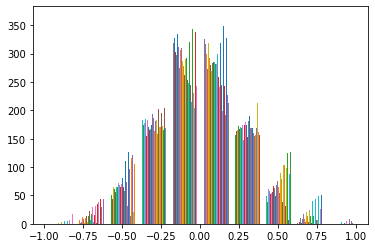

In [25]:
plt.hist(RS_mean)

In [ ]:
h_RS(0,0,0.1231,0.123142, 0.5)

(-2759.493134236145-524.8514672028622j)

In [ ]:
# RS methods calculation
'''
RS_result = np.zeros((M, M))
for x1 in range(M):
    for y1 in range(M):
        if mesh[x1, y1] == 0:
            pass
        else:
            RS_sum = np.zeros((M, M))
            x = ((x1 - M) / 2) * pp
            y = ((y1 - M) / 2) * pp
            for i in range(M):
                for j in range(M):
                    x2 = ((i - M) / 2 ) * pp
                    y2 = ((j - M) / 2 ) * pp
                    RS_sum[i, j] = mesh[x1, y1] * h_RS(x, y, x2, y2, z1)
            RS_result = RS_result + RS_sum
            print(x1, y1, "cell ready")
 
plt.imshow(np.abs(RS_result) / np.max(RS_result), cmap='gray')
plt.title('RS propagation')
'''


In [ ]:
kernel = np.zeros((M, M))
for i in range(M):
    for j in range(M):
        x = ((i-M) / 2 ) * pp
        y = ((j-M) / 2 ) * pp
        kernel[i, j] = h_RS(0, 0, x, y, 0.5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


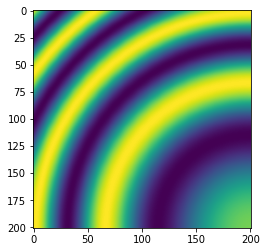

In [ ]:
plt.imshow(kernel)

# Reconstruction image with ASM

angular spectrum methods를 사용하여 이미지를 다시 복원하는 과정

In [ ]:
# Reconst image with ASM
res = height / 2
def asm_kernel(f):
    kernal = np.zeros((height // 2, height // 2))
    asm = -2j * np.pi * f
    for i in np.arange(height // 2):
        for j in np.arange(height // 2):
            c = (-pp * res / 2 + pp / 2) + i * pp
            r = (-pp * res / 2 + pp / 2) + j * pp
            squrt = wvl ** -2 - ((r / pp - 0.5) / pp / res) ** 2 - ((c / pp - 0.5) / pp / res) ** 2
            kernal[[j], [i]] = np.exp(asm * np.sqrt(squrt))
    return kernal